In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from tqdm import tqdm_notebook
from dtw import dtw,accelerated_dtw
import multiprocessing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-white')
orange, purple, elm ='#FFCC00', '#666599', '#217C7E'
blue, red, grey, green ='#336699', '#9A3334', '#AAAAAA', '#335333'
%matplotlib inline
mydpi=600
s=12

__author__ = 'HK Dambanemuya'
__version__ = 'Python2'

In [2]:
topics = ['social distancing', 'shelter in place', # Social Distancing
          'school closure', 'travel ban', # Restrictions
          'face mask', 'hand sanitizer', # PPE
          'medical supplies', 'test kits', # Medical Suppliesx
          'common cold', 'flu'] # Seasonal Flu
          

In [3]:
print ("Reading News...")
news = pd.read_csv("../Data/Fusion/news.csv")
news = news[news['length']>100]
news['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(news['date'])]

print ("Reading Blogs...")
blogs = pd.read_csv("../Data/Fusion/blogs.csv")
blogs = blogs[blogs['length']>100]
blogs['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(blogs['date'])]

print ("Reading Discussions...")
discussions = pd.read_csv("../Data/Fusion/discussions.csv")
discussions = discussions[discussions['length']>100]
discussions['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(discussions['date'])]

Reading News...



Reading Blogs...



Reading Discussions...


In [4]:
dates = sorted(list(set(news['date']).union(set(blogs['date'])).union(set(discussions['date']))))[1:-1]

In [5]:
def assign_topic(text):

    topic = 'COVID'
    text = str(text).lower()
    
    # Medical Supplies
    if 'medical suppl' in text:
        topic = topic + ', medical supplies'
    if 'test kit' in text:
        topic = topic + ', test kits'
    
    # PPE
    if 'face mask' in text: 
        topic = topic + ', face mask'
    if 'hand sanitizer' in text:
        topic = topic + ', hand sanitizer'
        
    # Recommendations
    if 'social distanc' in text:
        topic = topic + ', social distancing'
    if ('stay at home' or 'stayathome' or 'stay-at-home' or 'work from home' or 'shelter in place') in text:
        topic = topic + ', shelter in place'
        
    # Restrictions
    if ('travel ban' or 'travel restriction') in text:
        topic = topic + ', travel ban'
    if 'school clos' in text:
        topic = topic + ', school closure'
    
    # Seasonal Flu
    if 'common cold' in text:
        topic = topic + ', common cold'
    if ('flu ' or 'flu-' or 'flu.' or 'flu:' or 'flu;' or 'flu"') in text:
        topic = topic + ', flu'

    return topic

def assign_theme(text):

    theme = 'COVID'
    text = str(text).lower()
    
    # Medical Supplies
    if 'medical suppl' in text:
        theme = theme + ', medical supplies'
    if 'test kit' in text:
        theme = theme + ', medical supplies'
    
    # PPE
    if 'face mask' in text: 
        theme = theme + ', ppe'   
    if 'hand sanitizer' in text:
        theme = theme + ', ppe'
        
    # Recommendations
    if 'social distanc' in text:
        theme = theme + ', recommendations'
    if ('stay at home' or 'stayathome' or 'stay-at-home' or 'work from home' or 'shelter in place') in text:
        theme = theme + ', recommendations'
        
    # Restrictions
    if ('travel ban' or 'travel restriction') in text:
        theme = theme + ', restrictions'
    if 'school clos' in text:
        theme = theme + ', restrictions'
    
    # Seasonal Flu
    if 'common cold' in text:
        theme = theme + ', seasonal flu'
    if ('flu ' or 'flu-' or 'flu.' or 'flu:' or 'flu;' or 'flu"') in text:
        theme = theme + ', seasonal flu'


    return theme

In [6]:
pool = multiprocessing.Pool(processes=8)

In [7]:
news['topic'] = pool.map(assign_topic, news['text'])
news['theme'] = pool.map(assign_theme, news['text'])

In [8]:
blogs['topic'] = pool.map(assign_topic, blogs['text'])
blogs['theme'] = pool.map(assign_theme, blogs['text'])

In [9]:
discussions['topic'] = pool.map(assign_topic, discussions['text'])
discussions['theme'] = pool.map(assign_theme, discussions['text'])

In [10]:
news.to_csv("../Data/Fusion/news.csv", index=False)
blogs.to_csv("../Data/Fusion/blogs.csv", index=False)
discussions.to_csv("../Data/Fusion/discussions.csv", index=False)

In [11]:
def cov(arr):
    return np.true_divide(np.std(arr), np.mean(arr)) 

In [12]:
def get_topic_statistics(topic_list):
    
    sources = ['News', 'Blogs', 'Discussions']*len(topic_list)
    topics = []
    volume = []
    proportion = []
    variability = []
    popularity = []
    engagement = []
    prominence = []
    sentiment = []
    
    for topic in tqdm_notebook(topic_list):
        
        topics.extend([topic]*3)
        
        # Topic Volume: Total number of articles that belong to topic
        volume.extend([len(news[news['topic'].str.contains(topic)]),
                       len(blogs[blogs['topic'].str.contains(topic)]),
                       len(discussions[discussions['topic'].str.contains(topic)])])
        
        # Topic Share: Number of articles that belong to topic / total number of articles   
        proportion.extend([np.true_divide(len(news[news['topic'].str.contains(topic)]),len(news))*100,
                           np.true_divide(len(blogs[blogs['topic'].str.contains(topic)]),len(blogs))*100,
                           np.true_divide(len(discussions[discussions['topic'].str.contains(topic)]),len(discussions))*100])
                                         
        # Topic Variability: Coefficient of variation in topic's daily volume
        variability.extend([cov(news[news['topic'].str.contains(topic)][['date', 'text']].groupby('date').agg('count')['text'].values),
                           cov(blogs[blogs['topic'].str.contains(topic)][['date', 'text']].groupby('date').agg('count')['text'].values),
                           cov(discussions[discussions['topic'].str.contains(topic)][['date', 'text']].groupby('date').agg('count')['text'].values)])
        
        # Topic Popularity: Total number of participants on the topic
        popularity.extend([news[news['topic'].str.contains(topic)]['participants'].sum(),
                       blogs[blogs['topic'].str.contains(topic)]['participants'].sum(),
                       discussions[discussions['topic'].str.contains(topic)]['participants'].sum()])
        
        # Topic Engagement: Total number of replies on the topic
        engagement.extend([news[news['topic'].str.contains(topic)]['replies'].sum(),
                       blogs[blogs['topic'].str.contains(topic)]['replies'].sum(),
                       discussions[discussions['topic'].str.contains(topic)]['replies'].sum()])
        
        # Topic Prominence: Total number of distinct days topic was reported or discussed in online media
        prominence.extend([news[news['topic'].str.contains(topic)]['date'].nunique(),
                       blogs[blogs['topic'].str.contains(topic)]['date'].nunique(),
                       discussions[discussions['topic'].str.contains(topic)]['date'].nunique()])
    
        # Topic Sentiment: VADER
        sentiment.extend([news[news['topic'].str.contains(topic)]['sentiment'].mean(),
                       blogs[blogs['topic'].str.contains(topic)]['sentiment'].mean(),
                       discussions[discussions['topic'].str.contains(topic)]['sentiment'].mean()])
        
    df = pd.DataFrame()
    df['Topic'] = topics
    df['Source'] = sources
    df['Volume'] = volume
    df['Proportion'] = proportion
    df['Variability'] = variability
    df['Popularity'] = popularity
    df['Engagement'] = engagement
    df['Prominence'] = prominence
    df['Sentiment'] = sentiment
    
    return df

In [13]:
def plot_topic_variable(variable, yscale='log'):
    
    ind = np.arange(len(topics))    
    width = 0.25
    if variable == 'Sentiment':
        fig = plt.figure(figsize=(5,10), dpi=mydpi)
        plt.style.use('seaborn-whitegrid')
        plt.barh(ind, topic_statistics[topic_statistics['Source'].str.contains('News')][variable], width, color=elm, label='News Articles')
        plt.barh(ind+width, topic_statistics[topic_statistics['Source']=='Blogs'][variable], width, color=orange, label='Blog Posts')
        plt.barh(ind+width*2, topic_statistics[topic_statistics['Source']=='Discussions'][variable], width, color=purple, label='Discussions')
        plt.yticks(np.arange(len(topics)), topics)
        plt.xlabel("Topic {}".format(variable), fontsize=14)
        plt.yticks(ind + 0.35, fontsize=14)
        plt.xticks(fontsize=14)
        plt.xscale(yscale)
        plt.legend(loc='best', ncol=3, bbox_to_anchor=(0, 0, 1, 1.12))
        plt.show()
    else:
        fig = plt.figure(figsize=(10,5), dpi=mydpi)
        plt.bar(ind, topic_statistics[topic_statistics['Source'].str.contains('News')][variable], width, color=elm, label='News Articles')
        plt.bar(ind+width, topic_statistics[topic_statistics['Source']=='Blogs'][variable], width, color=orange, label='Blog Posts')
        plt.bar(ind+width*2, topic_statistics[topic_statistics['Source']=='Discussions'][variable], width, color=purple, label='Discussions')
        plt.xticks(np.arange(len(topics)), topics, rotation=270)
        plt.ylabel("Topic {}".format(variable), fontsize=14)
        plt.xticks(ind + 0.3, fontsize=14)
        plt.yticks(fontsize=14)
        plt.yscale(yscale)
        plt.legend(loc='best', ncol=3)
        plt.show()

In [14]:
topic_statistics = get_topic_statistics(topics)
topic_statistics.to_csv('../Results/topicstatistics.csv', index=False)
topic_statistics

,Topic,Source,Volume,Proportion,Variability,Popularity,Engagement,Prominence,Sentiment
0,social distancing,News,257773,11.094,1.755,243999,309003,69,0.358
1,social distancing,Blogs,99035,10.045,1.779,90246,7764,67,0.440
2,social distancing,Discussions,15307,3.714,1.550,271454,441366,64,0.130
3,shelter in place,News,88629,3.814,1.683,79747,105954,78,0.149
4,shelter in place,Blogs,30742,3.118,1.666,26243,1550,70,0.242
5,shelter in place,Discussions,6322,1.534,1.413,96758,151604,70,0.043
6,school closure,News,42145,1.814,1.477,38867,69878,72,0.271
7,school closure,Blogs,14267,1.447,1.400,12612,874,66,0.376
8,school closure,Discussions,1897,0.460,1.054,31203,53444,49,0.036
9,travel ban,News,48891,2.104,1.395,62280,246661,85,-0.242


In [15]:
topic_statistics.groupby('Topic').agg(['mean', 'std']).sort_values(by='Topic')

Volume            Proportion       Variability       Popularity             Engagement             Prominence        Sentiment      
                        mean        std       mean   std        mean   std       mean        std        mean         std       mean    std      mean   std
Topic                                                                                                                                                     
common cold       13940.667  10893.698  1.139      0.051 0.851       0.017 54360.333  53443.127  123681.667  105649.207  91.333     8.622  -0.326    0.071
face mask         43205.667  44441.963  2.877      1.246 0.813       0.064 67746.000  36081.817  69013.667   70593.862   82.667     6.028  -0.015    0.046
flu               62385.667  31942.534  6.208      2.693 1.044       0.109 420448.000 457450.164 1326854.333 1183088.411 95.667     14.012 -0.299    0.167
hand sanitizer    38500.000  36071.499  2.696      0.996 1.174       0.124 74343.000  46595.488  85837.000   100854.053  73.667     3.512  0.369     0.074
medical supplies  24790.000  26798.158  1.594      0.808 1.245       0.213 38191.333  21874.804  80306.667   85211.183   70.000     6.928  0.020     0.083
school closure    19436.333  20615.938  1.240      0.700 1.311       0.225 27560.667  13501.156  41398.667   36044.494   62.333     11.930 0.228     0.174
shelter in place  41897.667  42272.299  2.822      1.169 1.587       0.151 67582.667  36797.684  86369.333   76920.219   72.667     4.619  0.145     0.099
social distancing 124038.333 123151.595 8.284      3.993 1.695       0.126 201899.667 97664.478  252711.000  222214.458  66.667     2.517  0.309     0.160
test kits         17127.333  14923.575  1.320      0.118 1.090       0.122 52572.333  40493.523  136678.667  118867.538  72.333     5.508  -0.057    0.130
travel ban        23606.000  22857.095  1.650      0.529 1.322       0.077 45284.000  25777.476  115860.000  123412.194  77.000     6.928  -0.277    0.070

In [16]:
total= len(news) + len(blogs) + len(discussions)
print 'Total Data (>100 words):', total

Total Data (>100 words): 3721642


In [17]:
def proportion(arr):
    return np.true_divide(sum(arr),total)*100

In [18]:
topic_statistics[['Topic', 'Volume']].groupby('Topic').agg(['sum', proportion]).sort_values(by='Topic')

Volume           
                      sum proportion
Topic                               
common cold        41822  1.124     
face mask          129617 3.483     
flu                187157 5.029     
hand sanitizer     115500 3.103     
medical supplies   74370  1.998     
school closure     58309  1.567     
shelter in place   125693 3.377     
social distancing  372115 9.999     
test kits          51382  1.381     
travel ban         70818  1.903

In [19]:
print "Preserved {0}% of the original data by filtering posts > 100 words".format(round(np.true_divide(total, (2711460+1270925+1272150))*100,1))


Preserved 70.8% of the original data by filtering posts > 100 words


In [20]:
print "Total topic volume: ", sum([value for value in topic_statistics[['Topic', 'Volume']].groupby('Topic').agg(['sum']).sort_values(by='Topic').values])[0]


Total topic volume:  1226783


In [21]:
print "The 10 topics comprise {}% of the data.".format(round(sum([np.true_divide(value,total)*100 for value in topic_statistics[['Topic', 'Volume']].groupby('Topic').agg(['sum']).sort_values(by='Topic').values])
,2))


The 10 topics comprise 32.96% of the data.


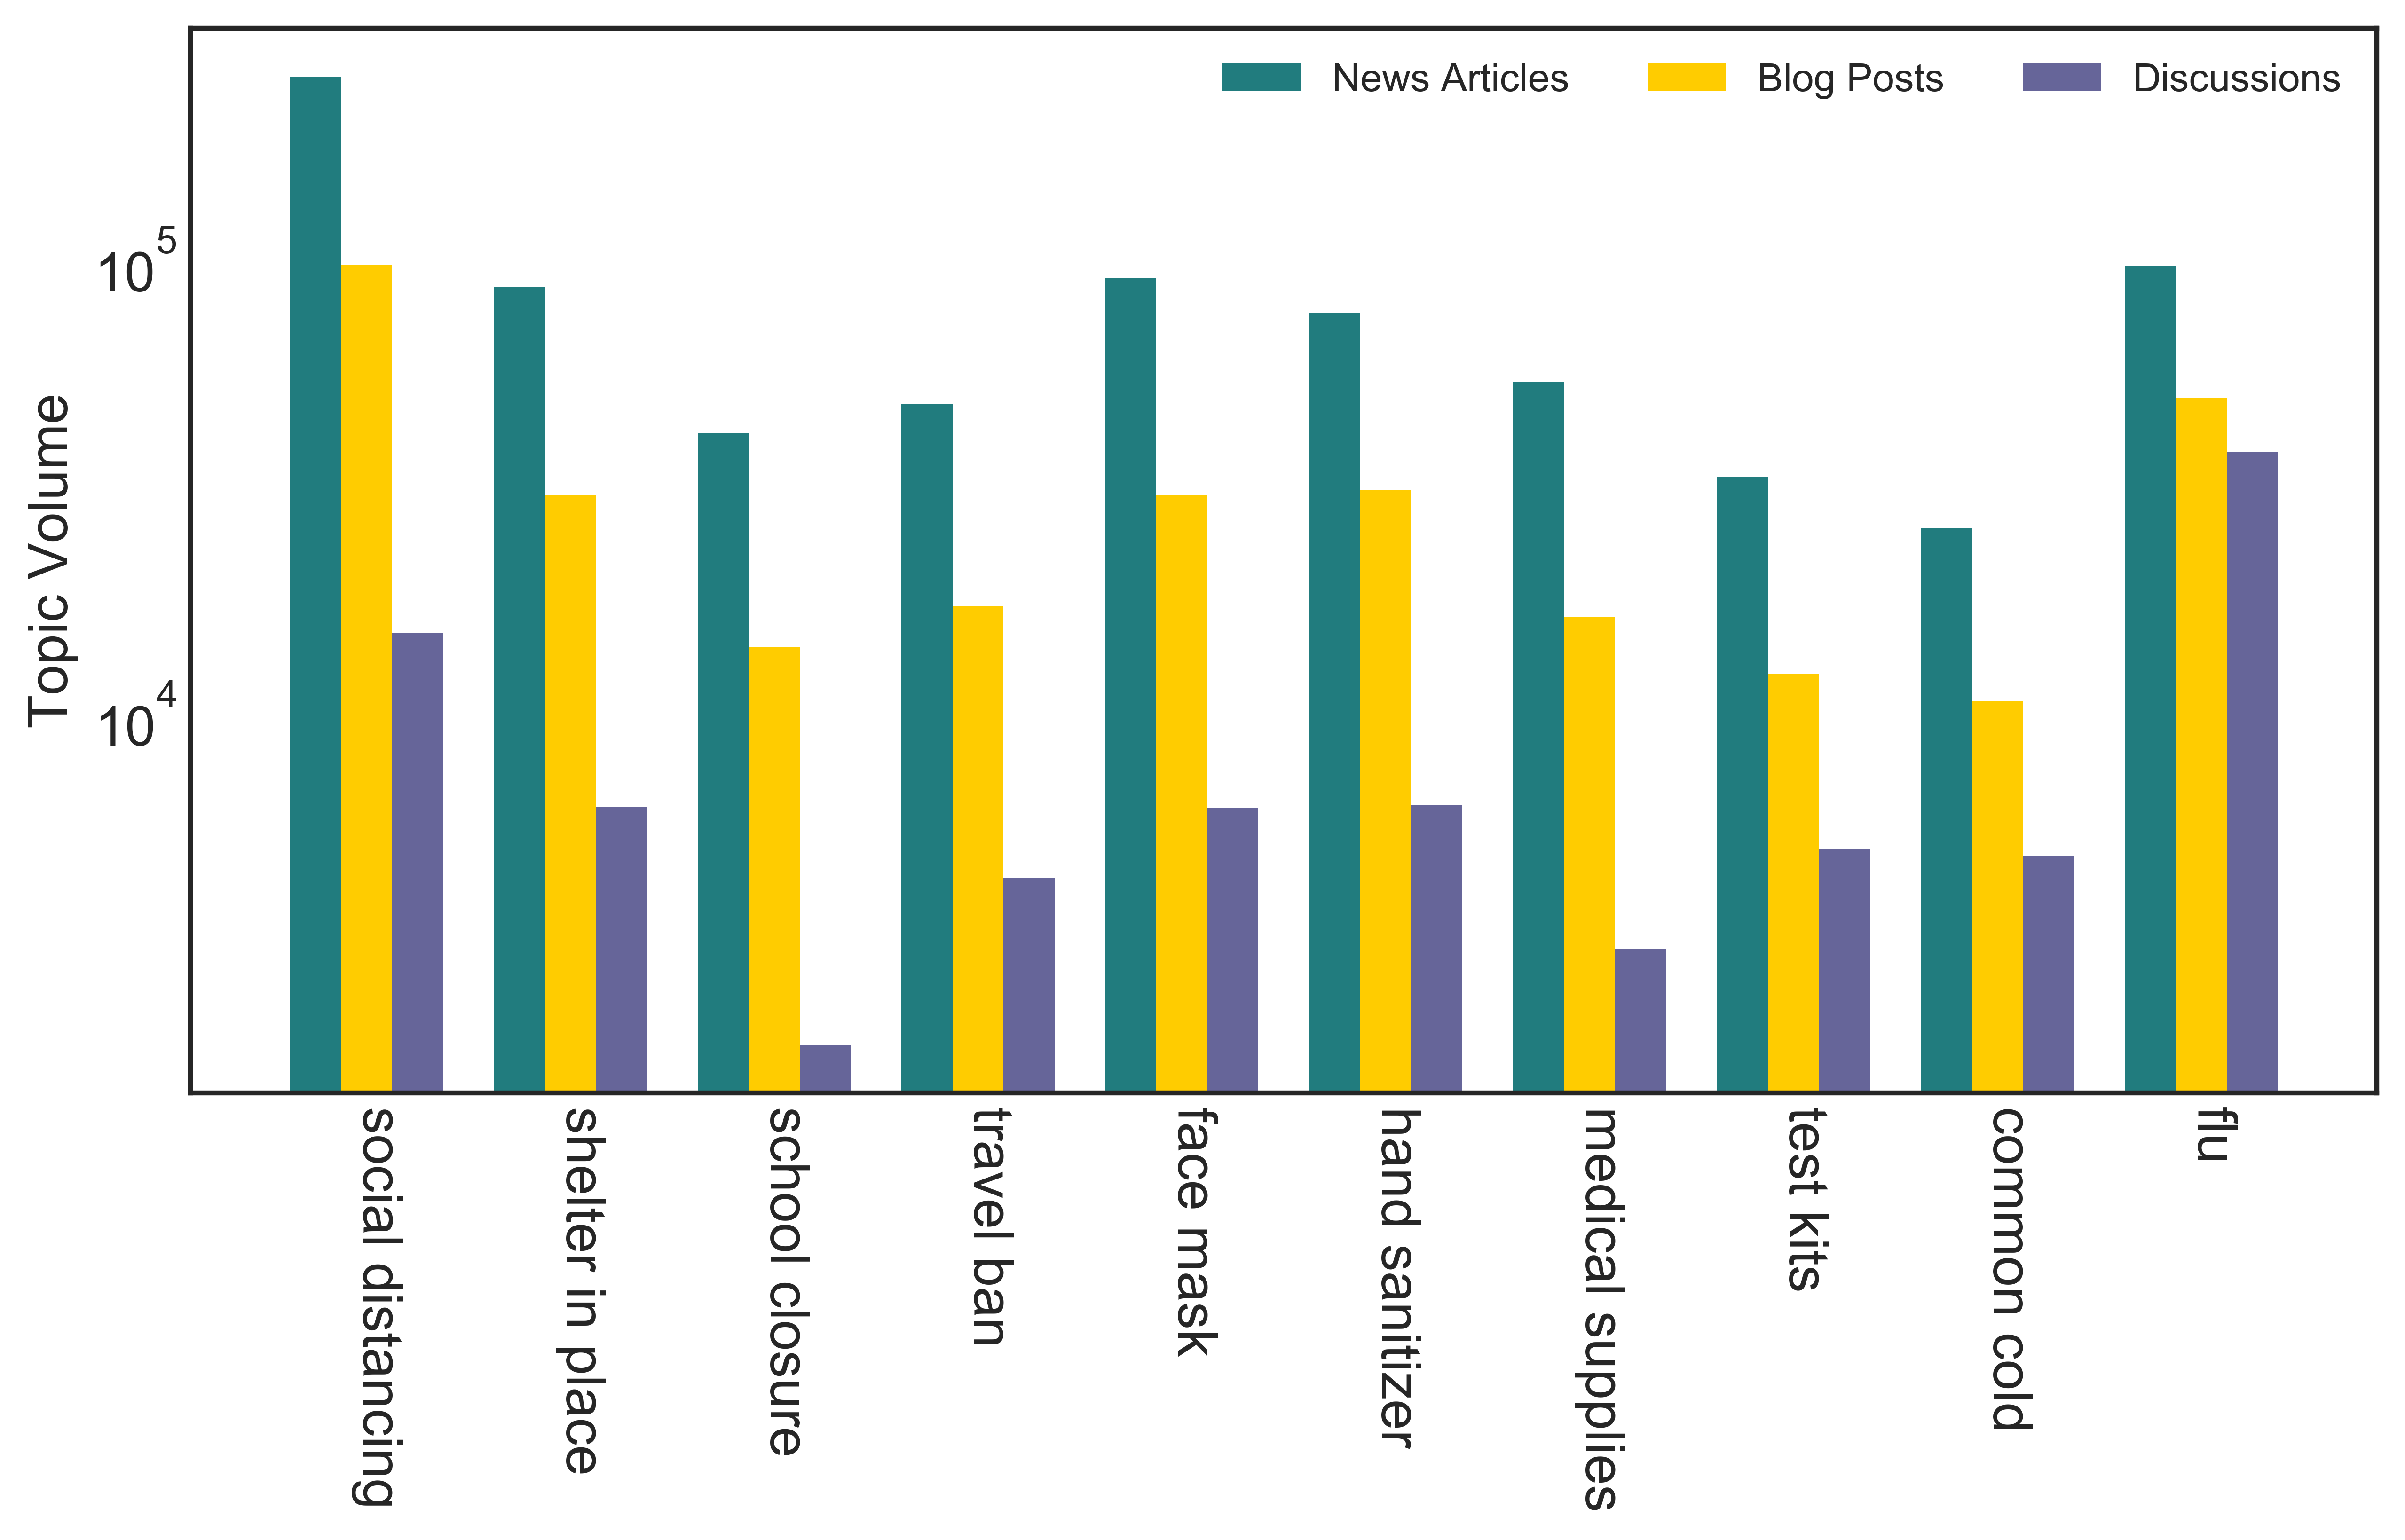

In [22]:
plot_topic_variable("Volume", yscale='log')

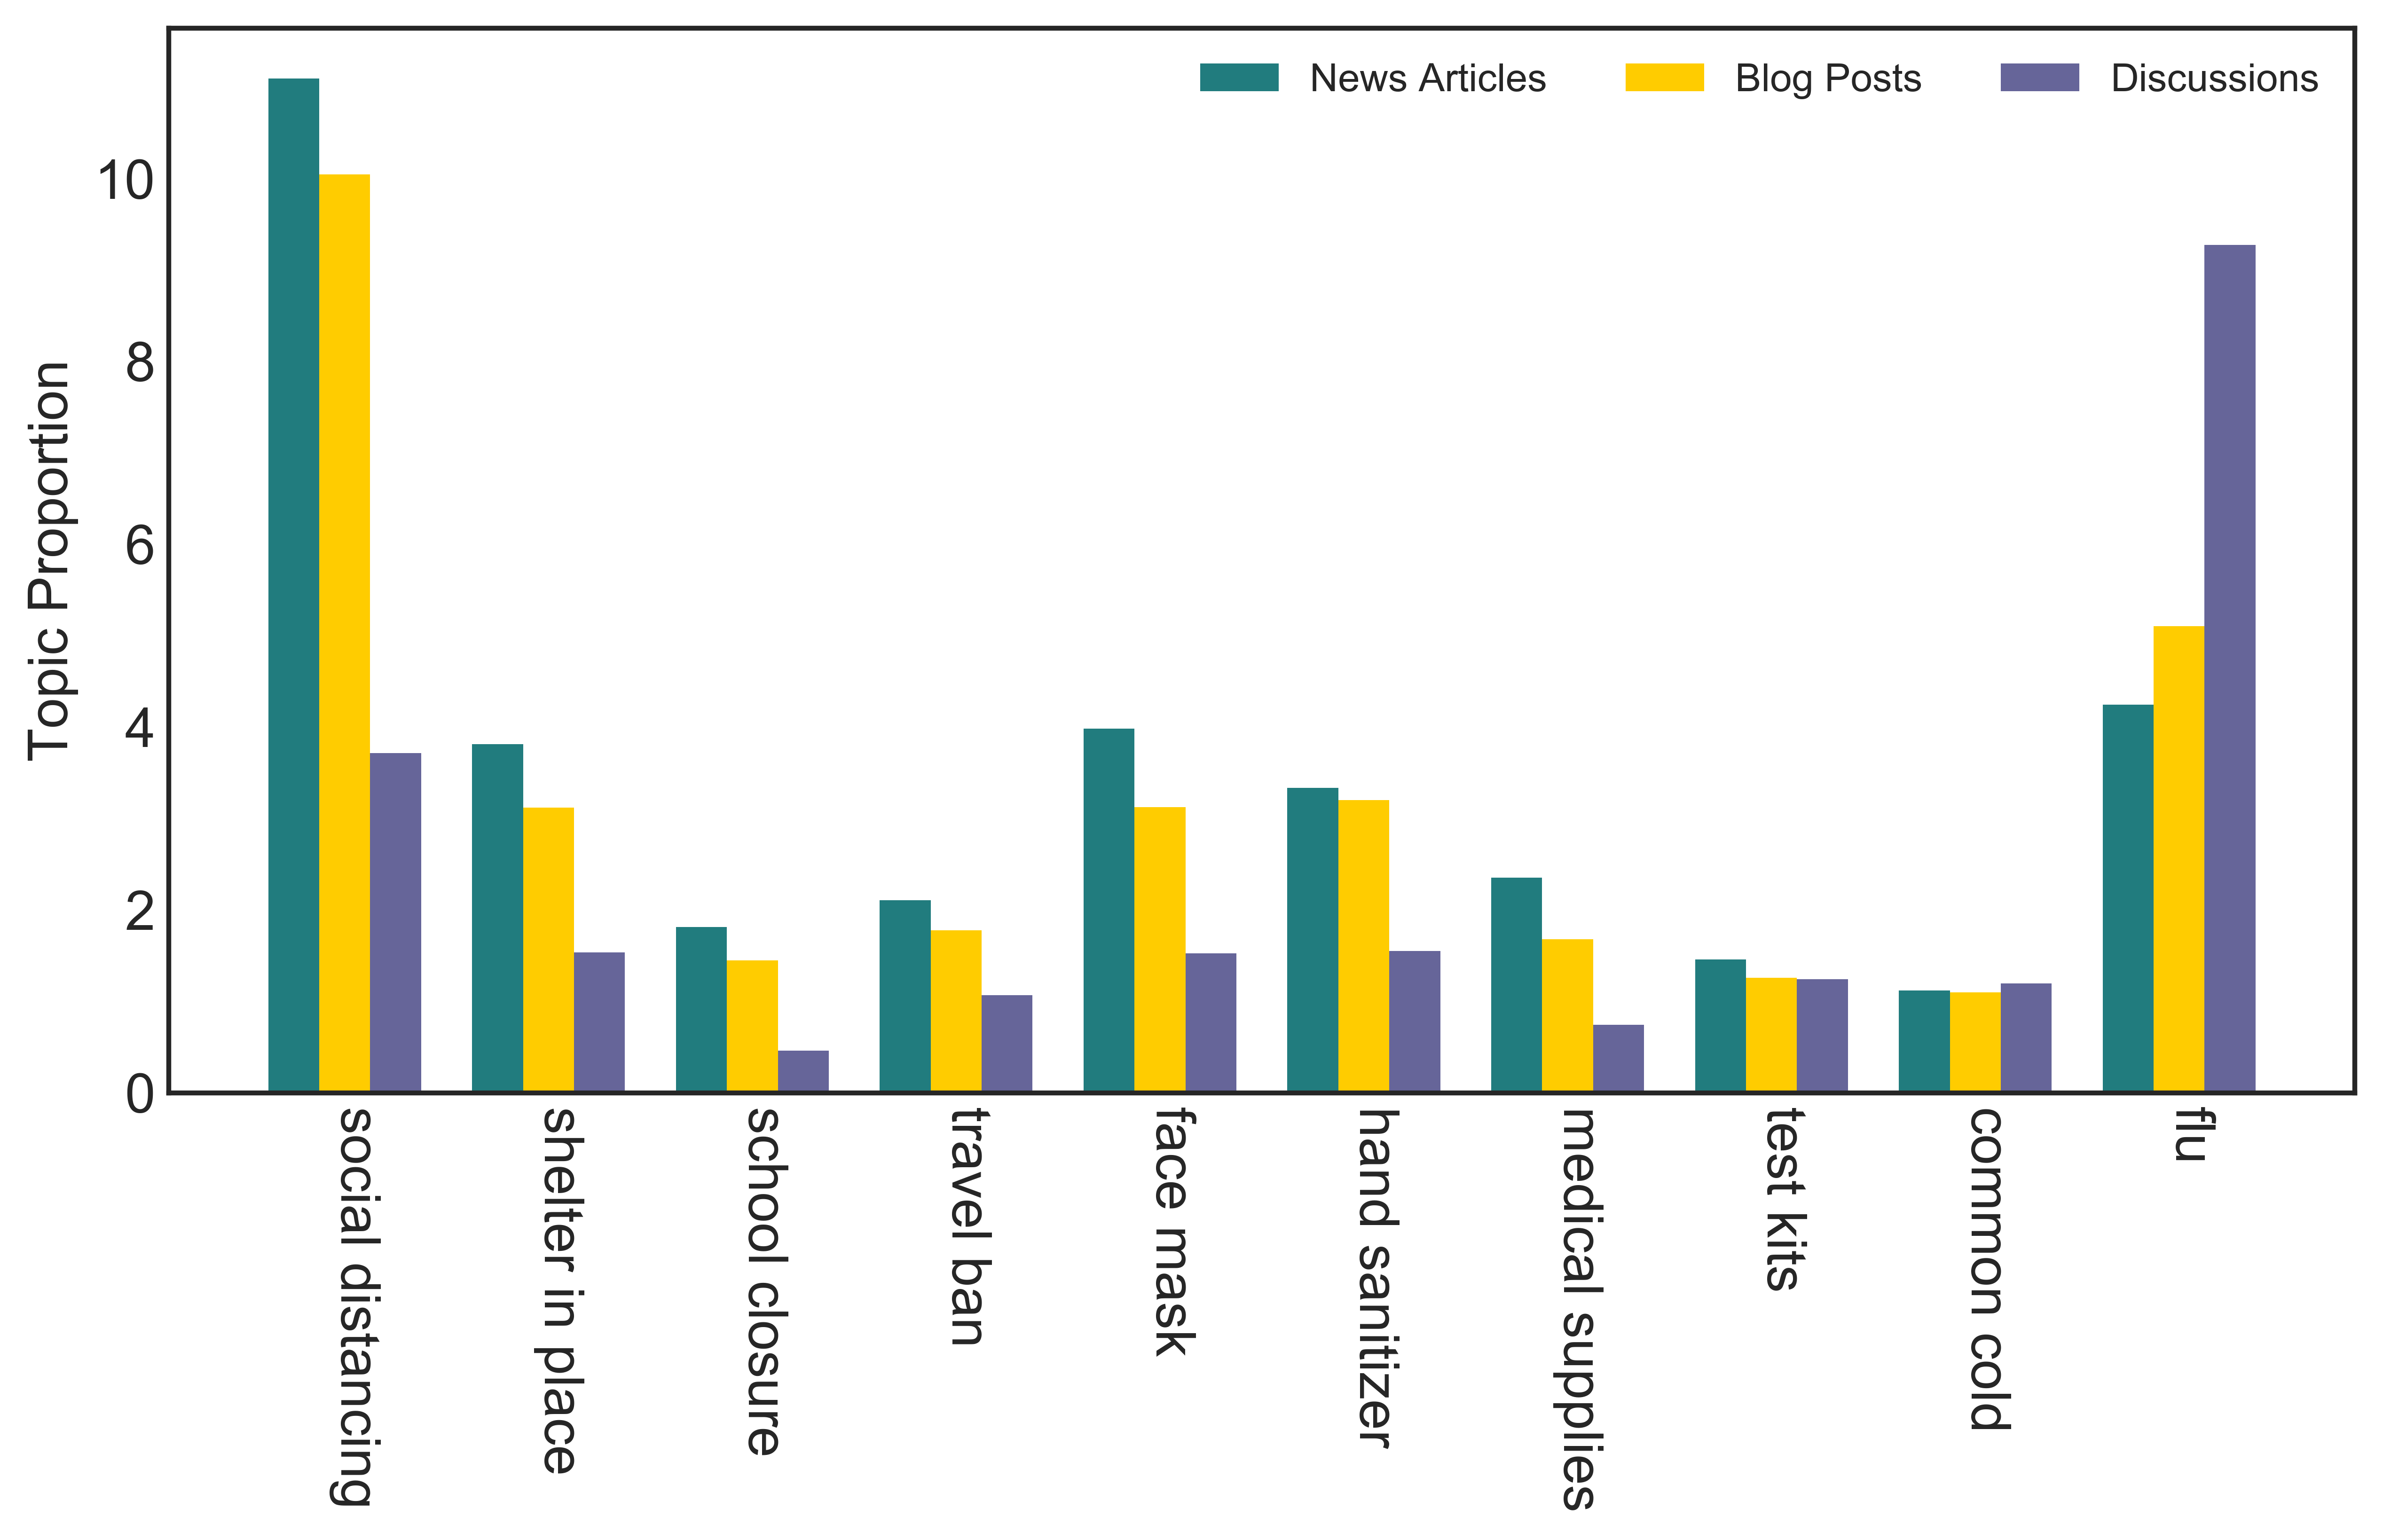

In [23]:
plot_topic_variable("Proportion", yscale='linear')

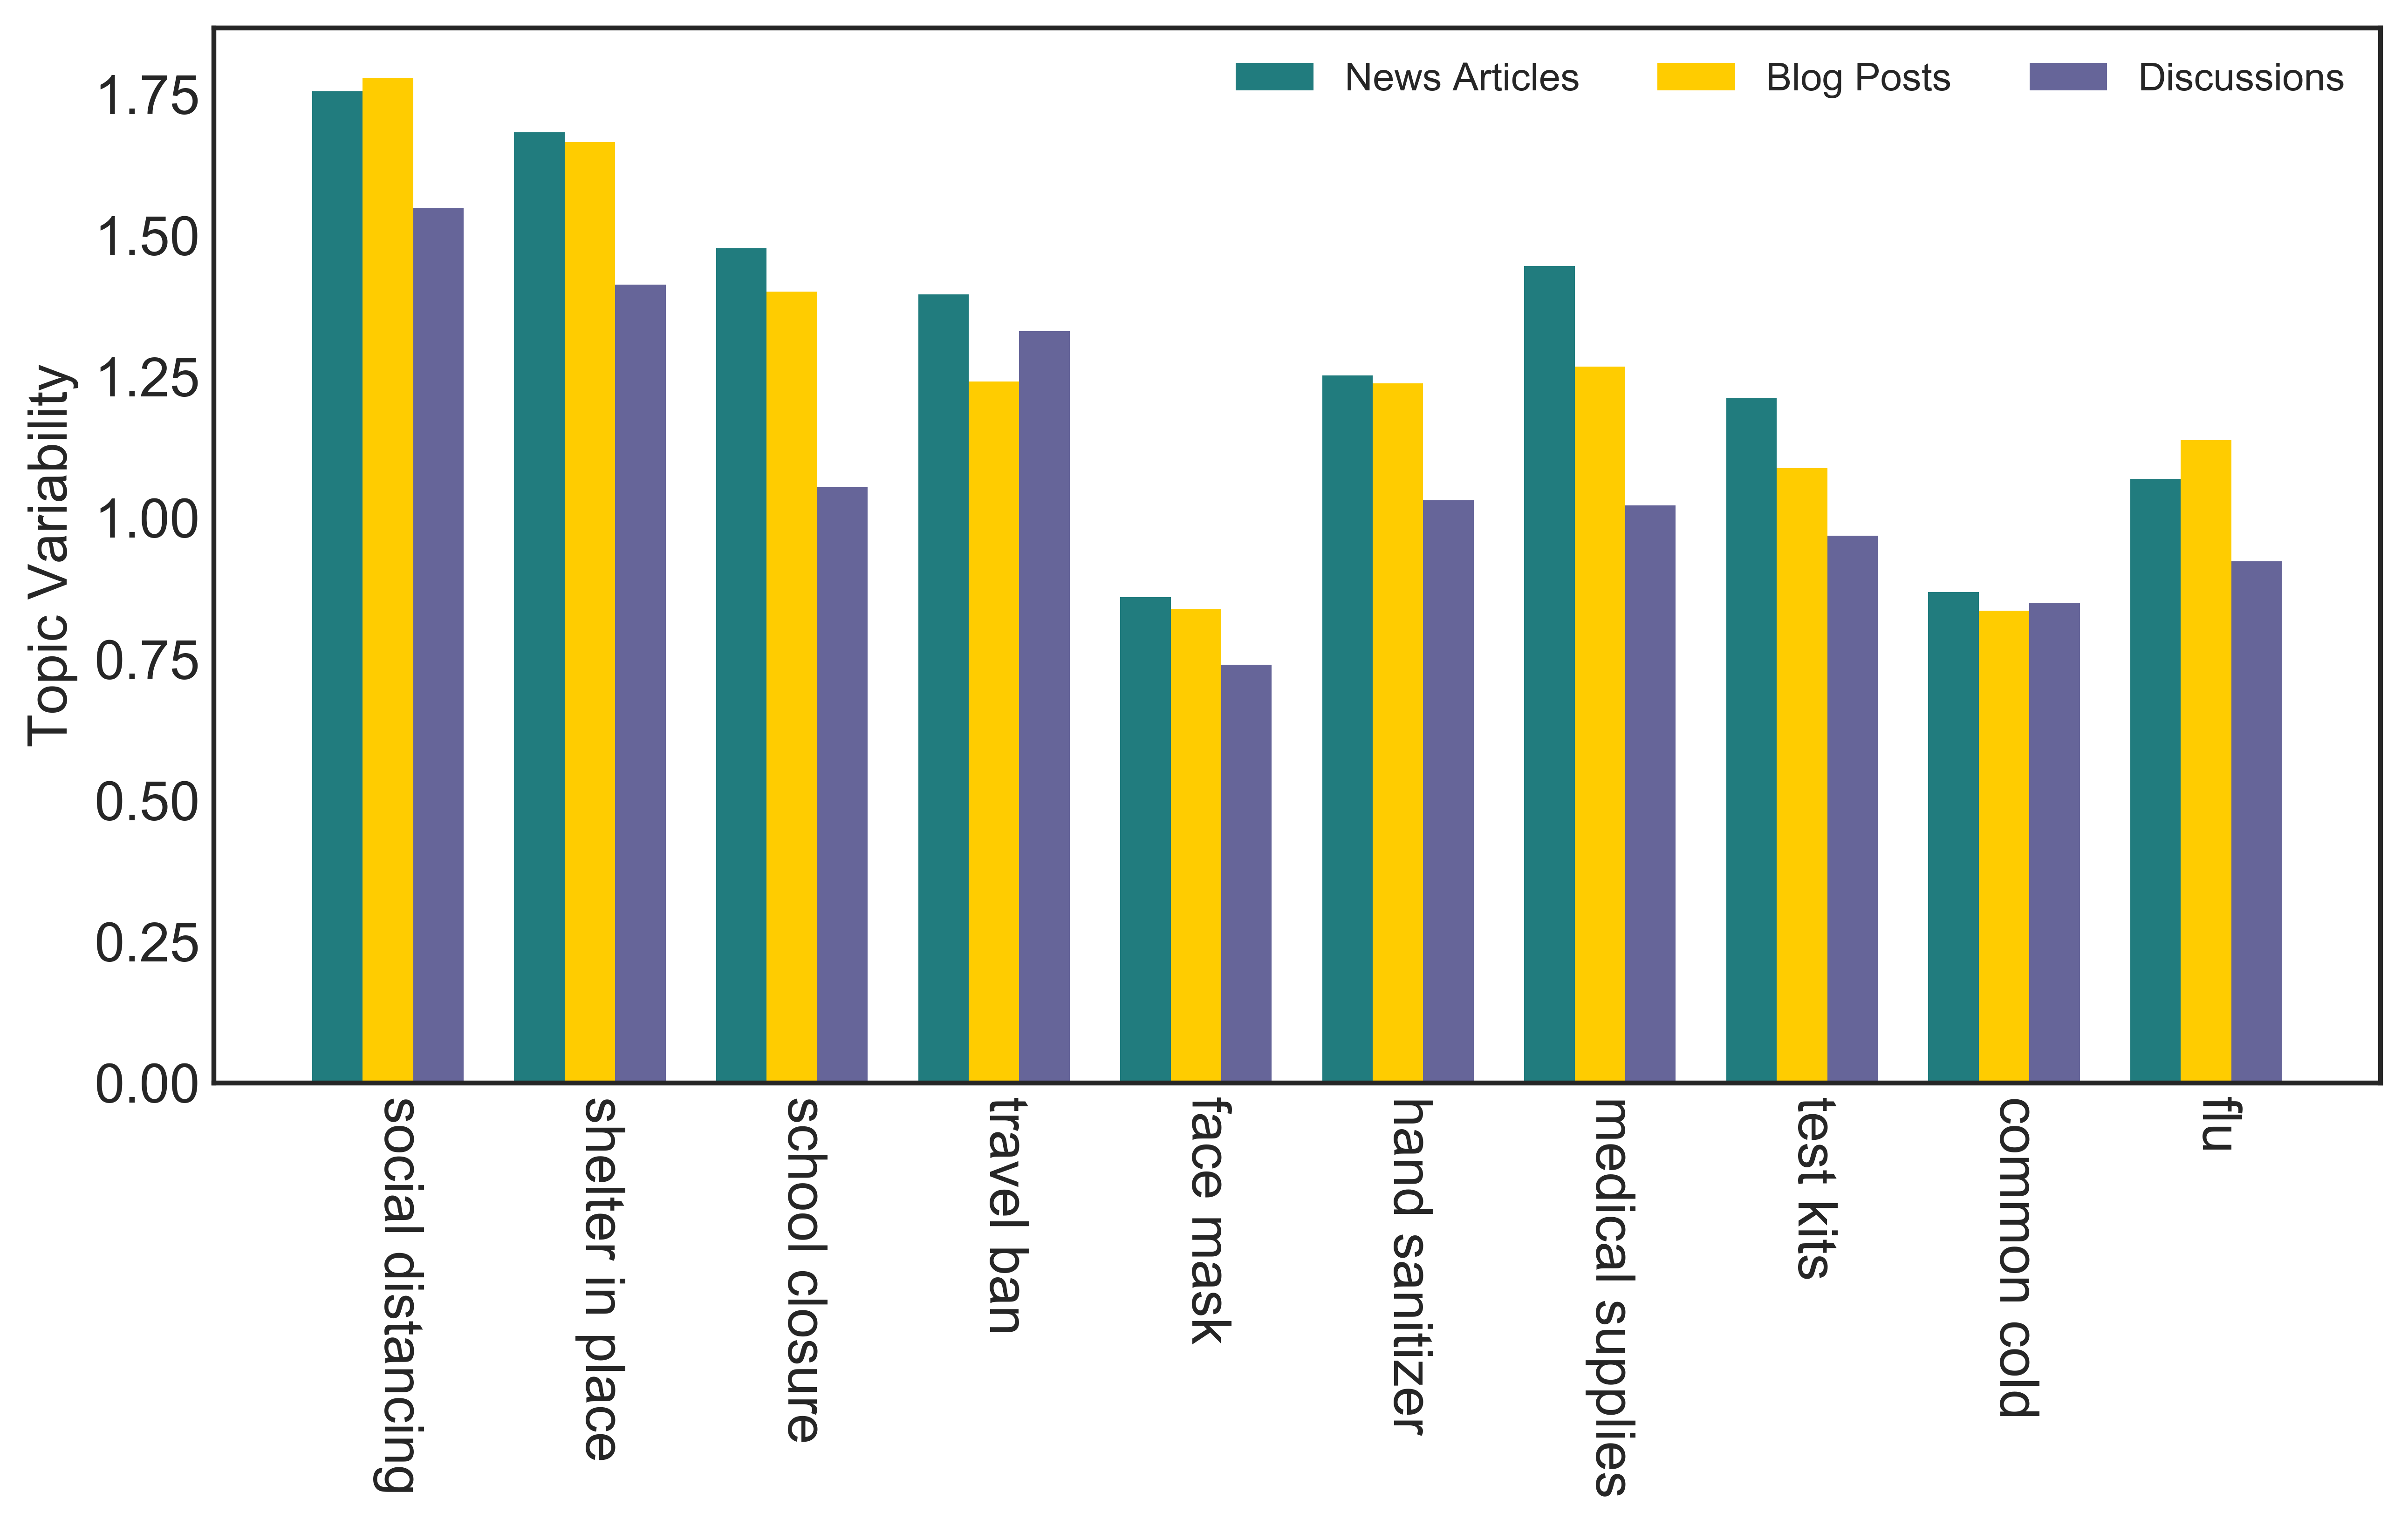

In [24]:
plot_topic_variable("Variability", yscale='linear')

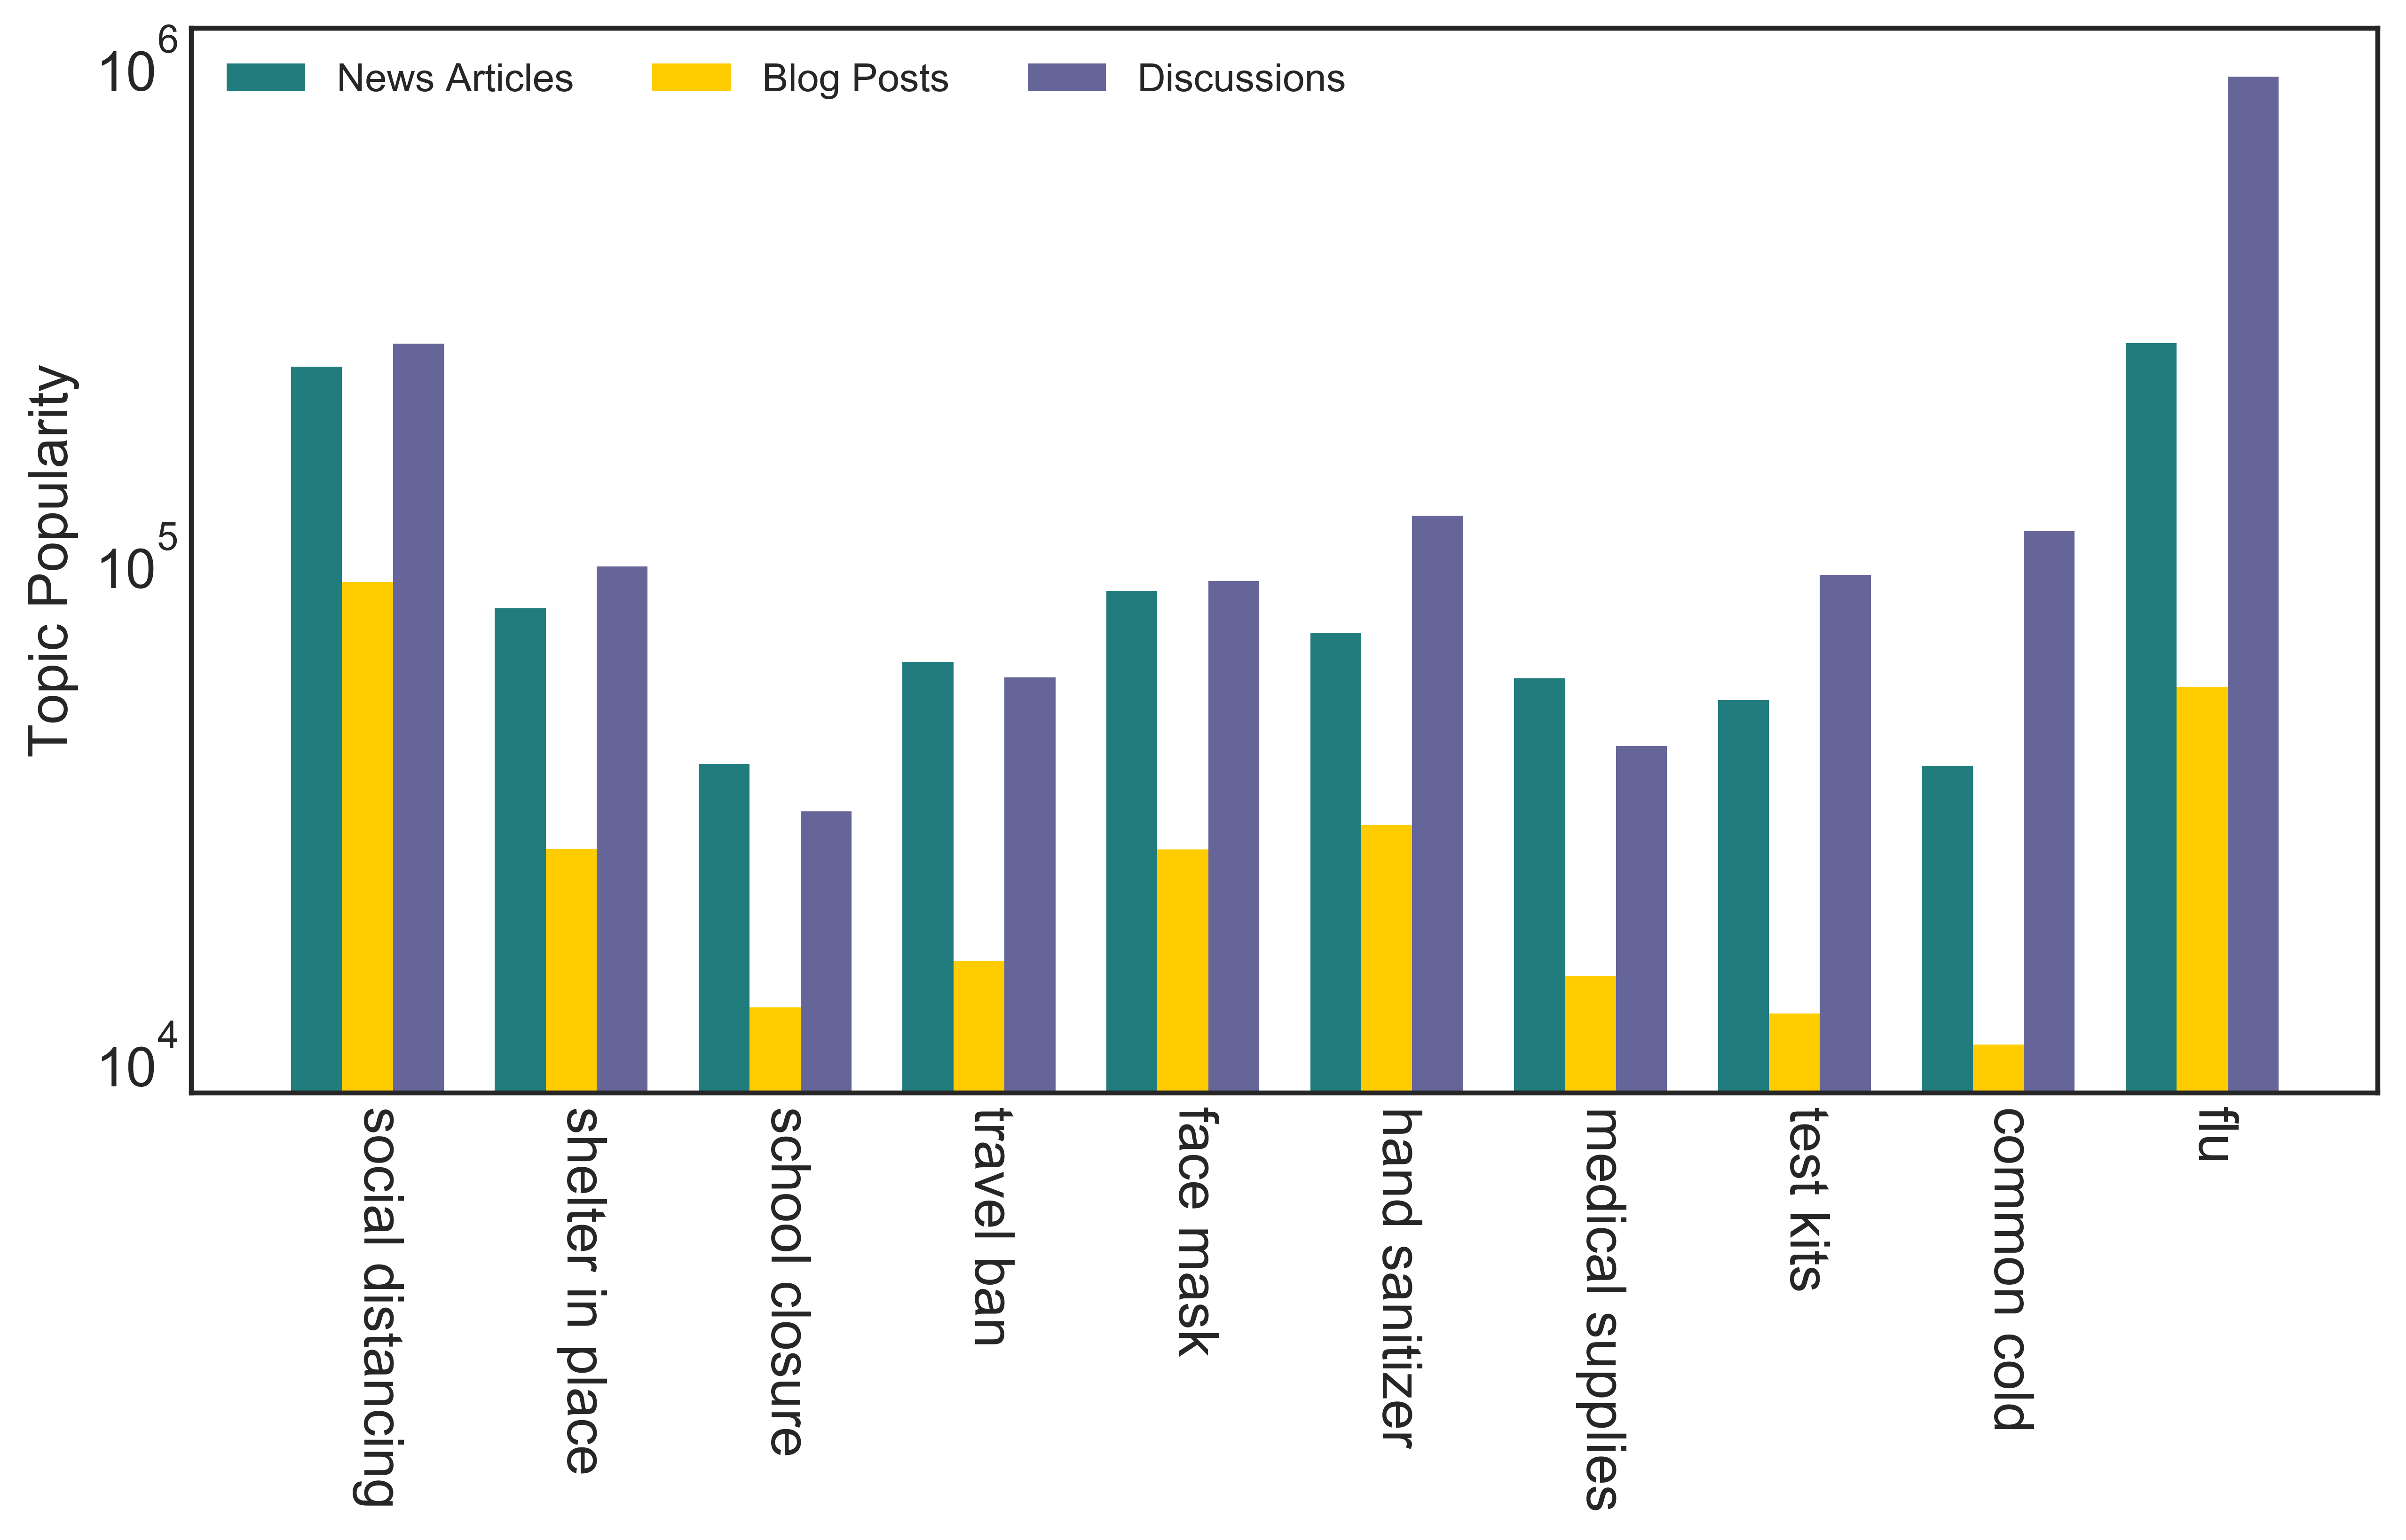

In [25]:
plot_topic_variable("Popularity")

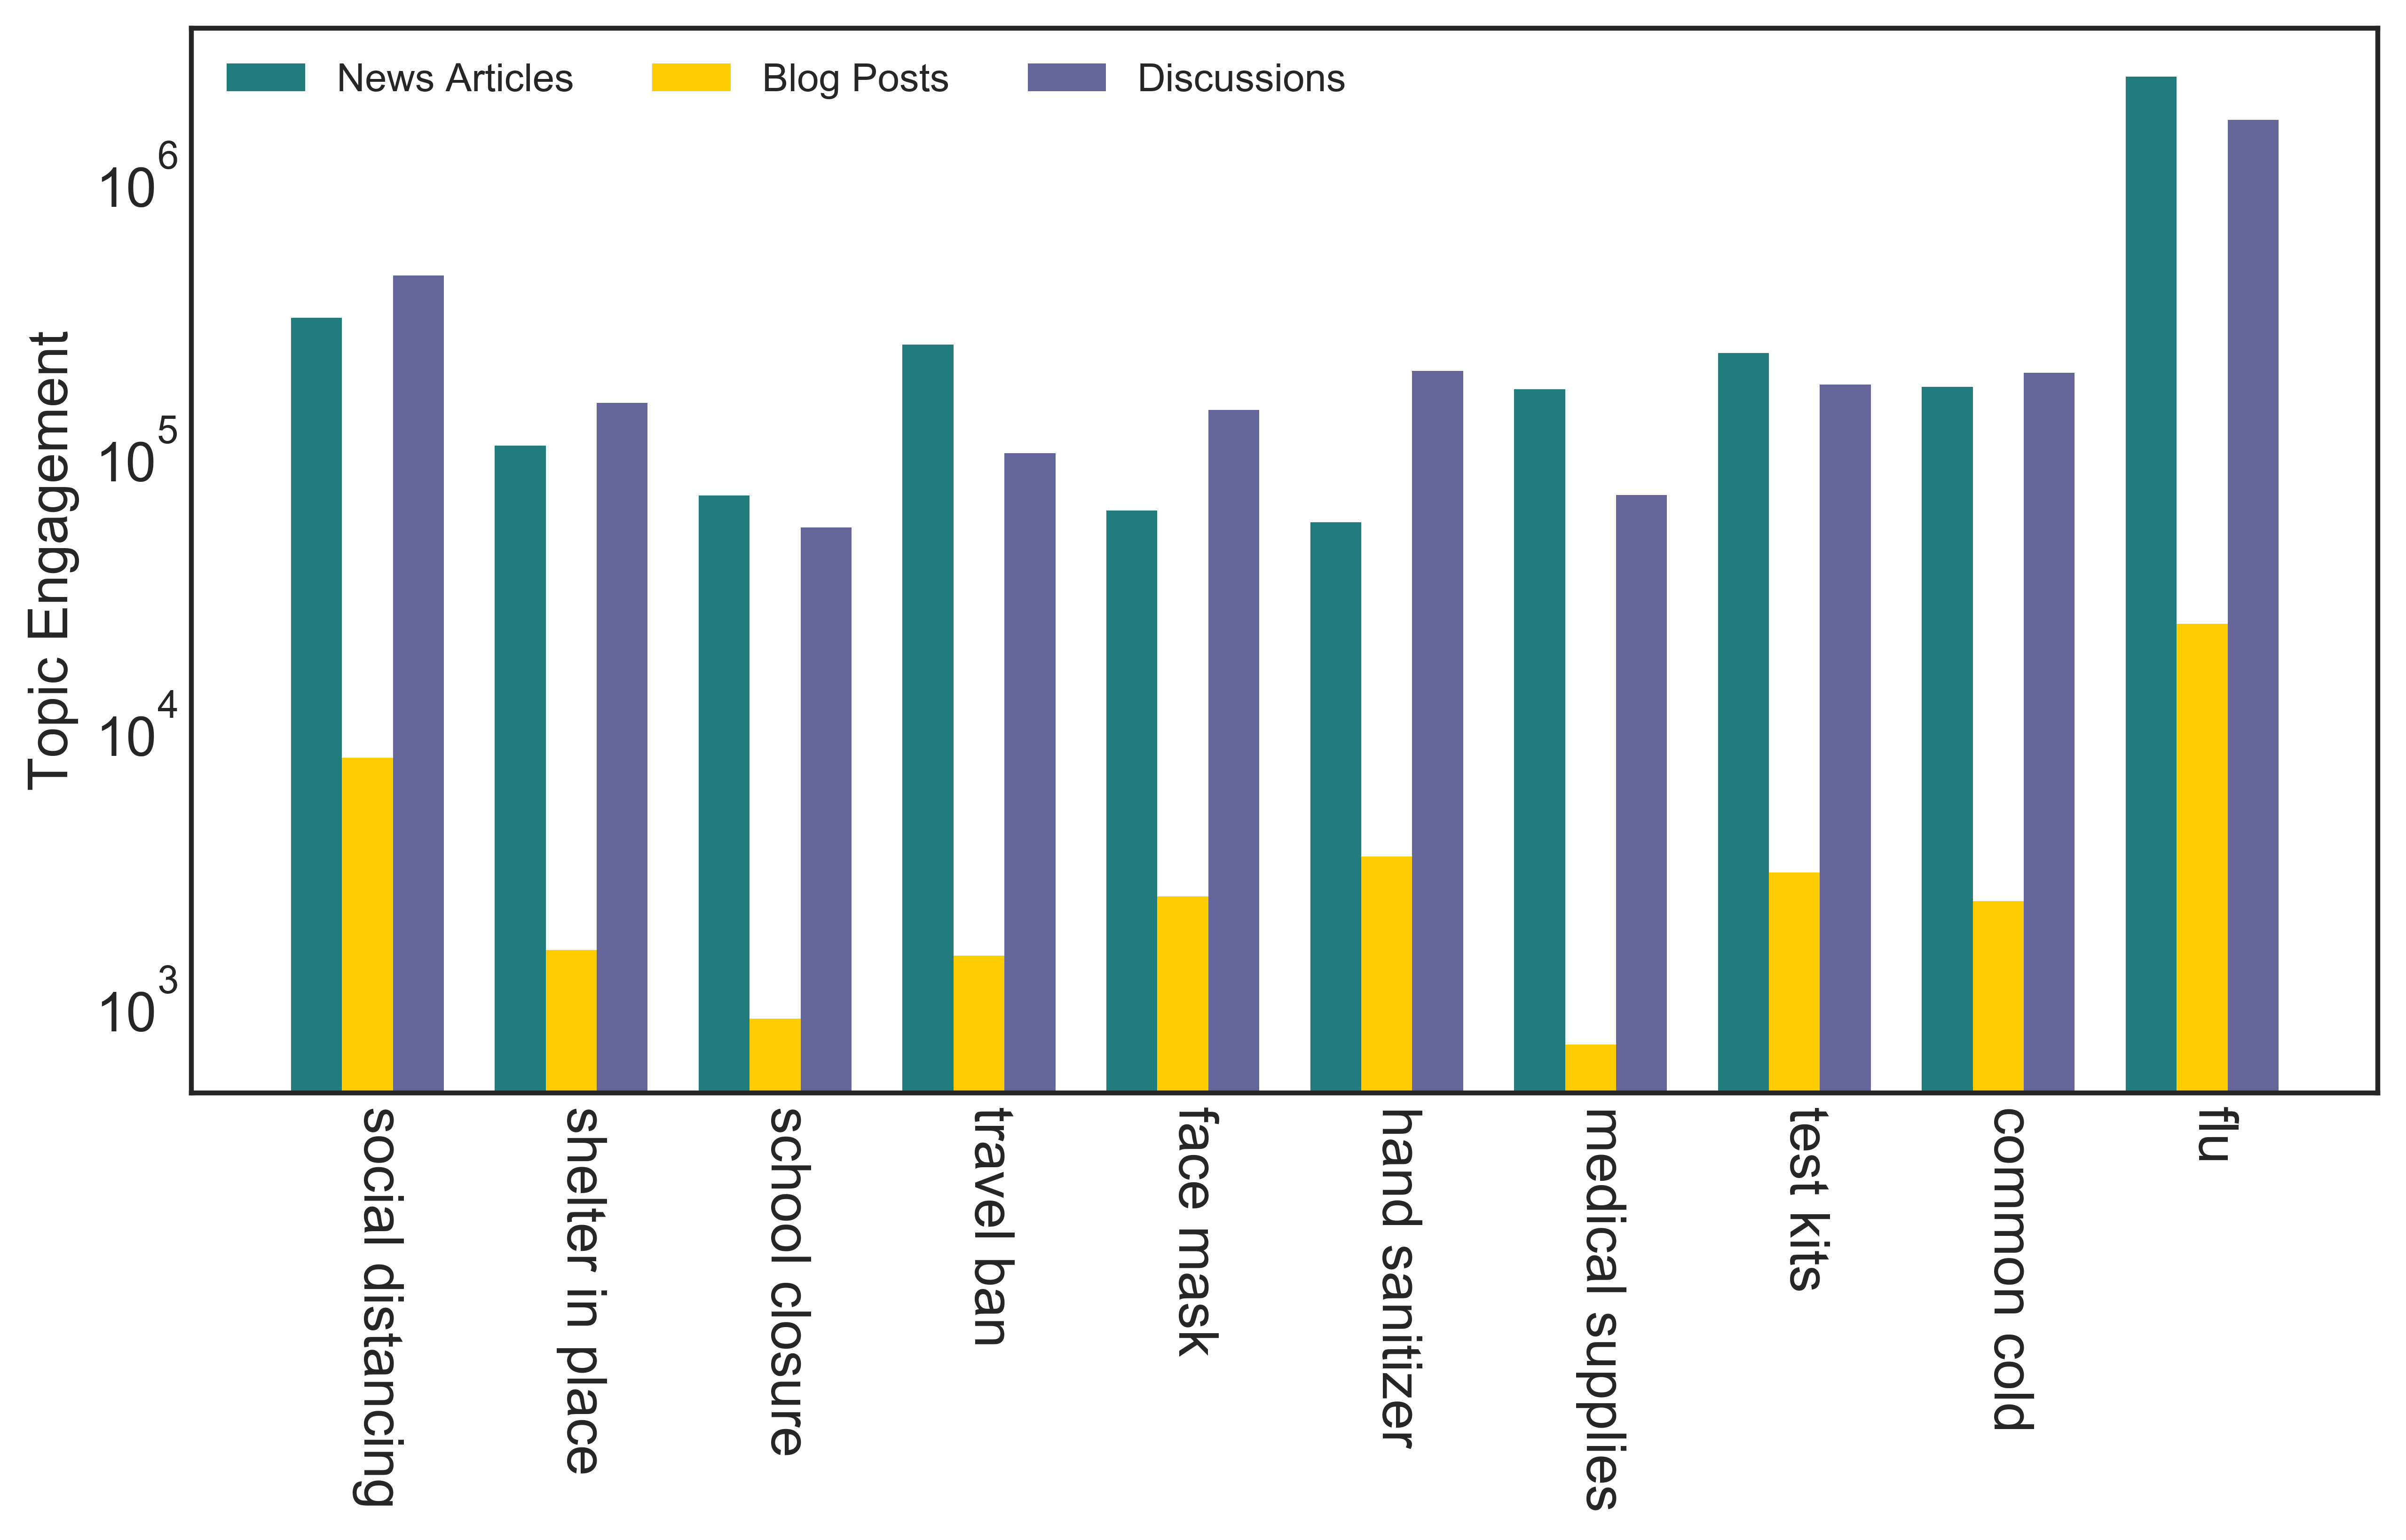

In [26]:
plot_topic_variable("Engagement")

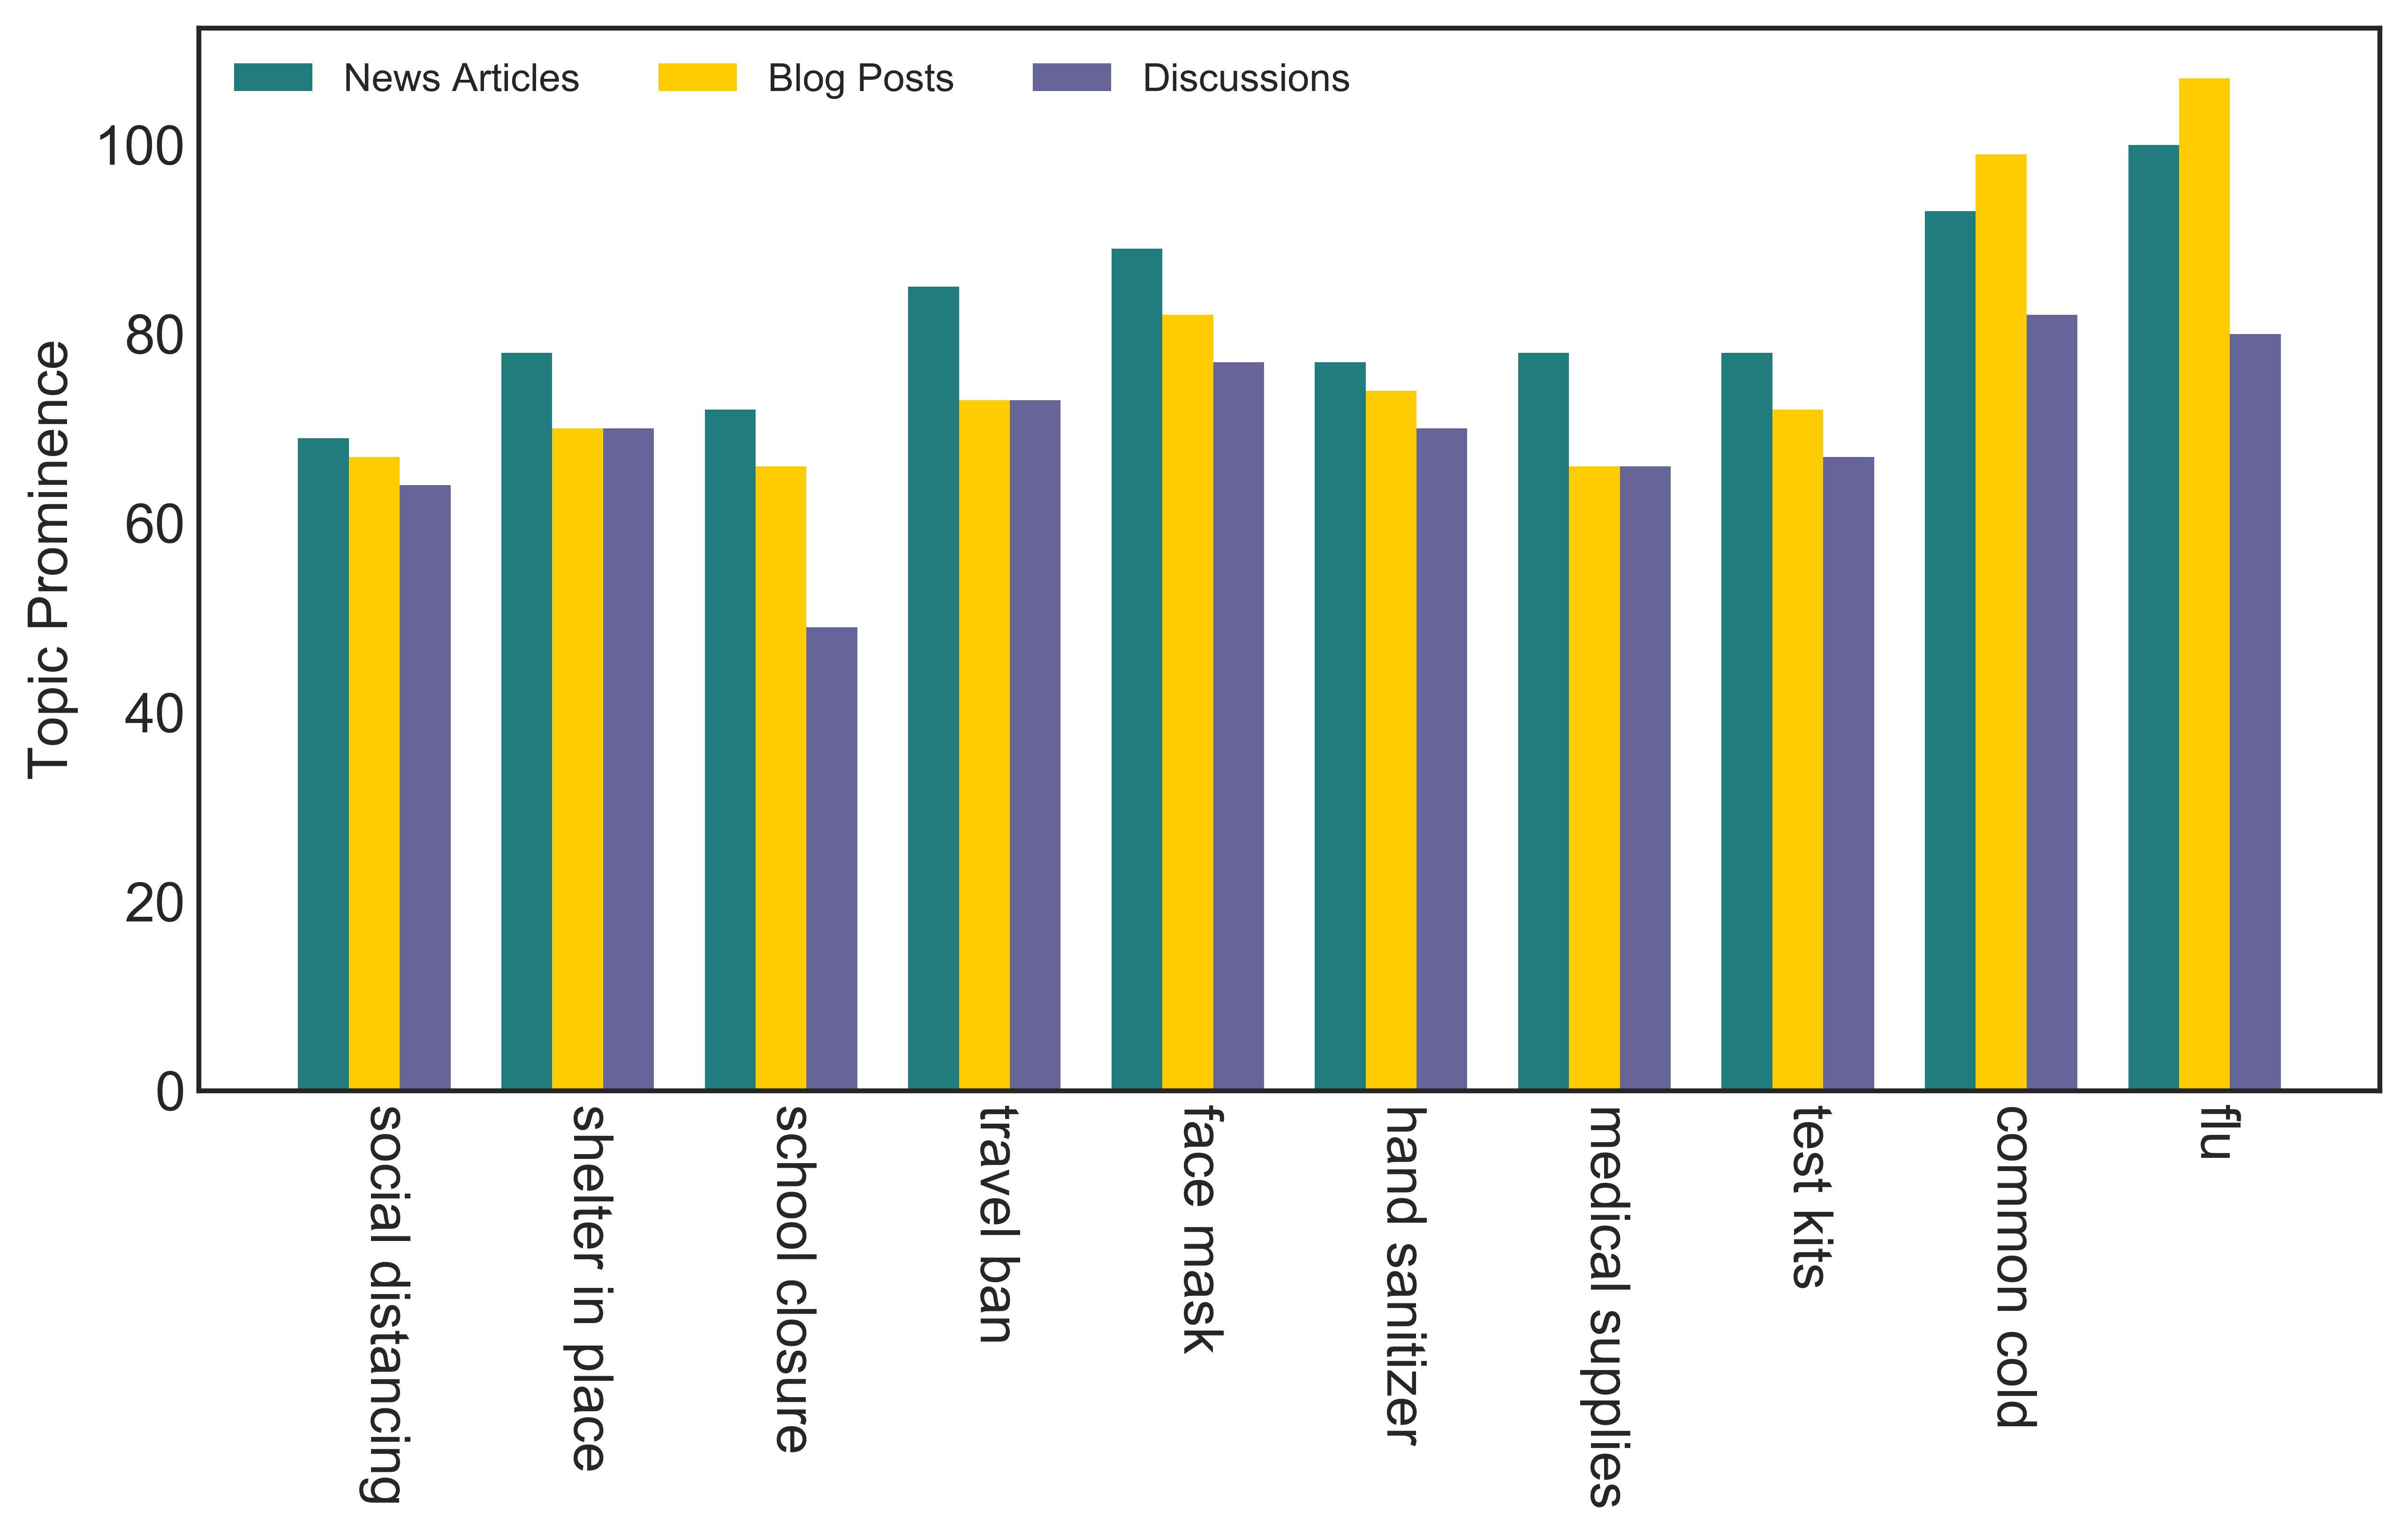

In [27]:
plot_topic_variable("Prominence", yscale='linear')

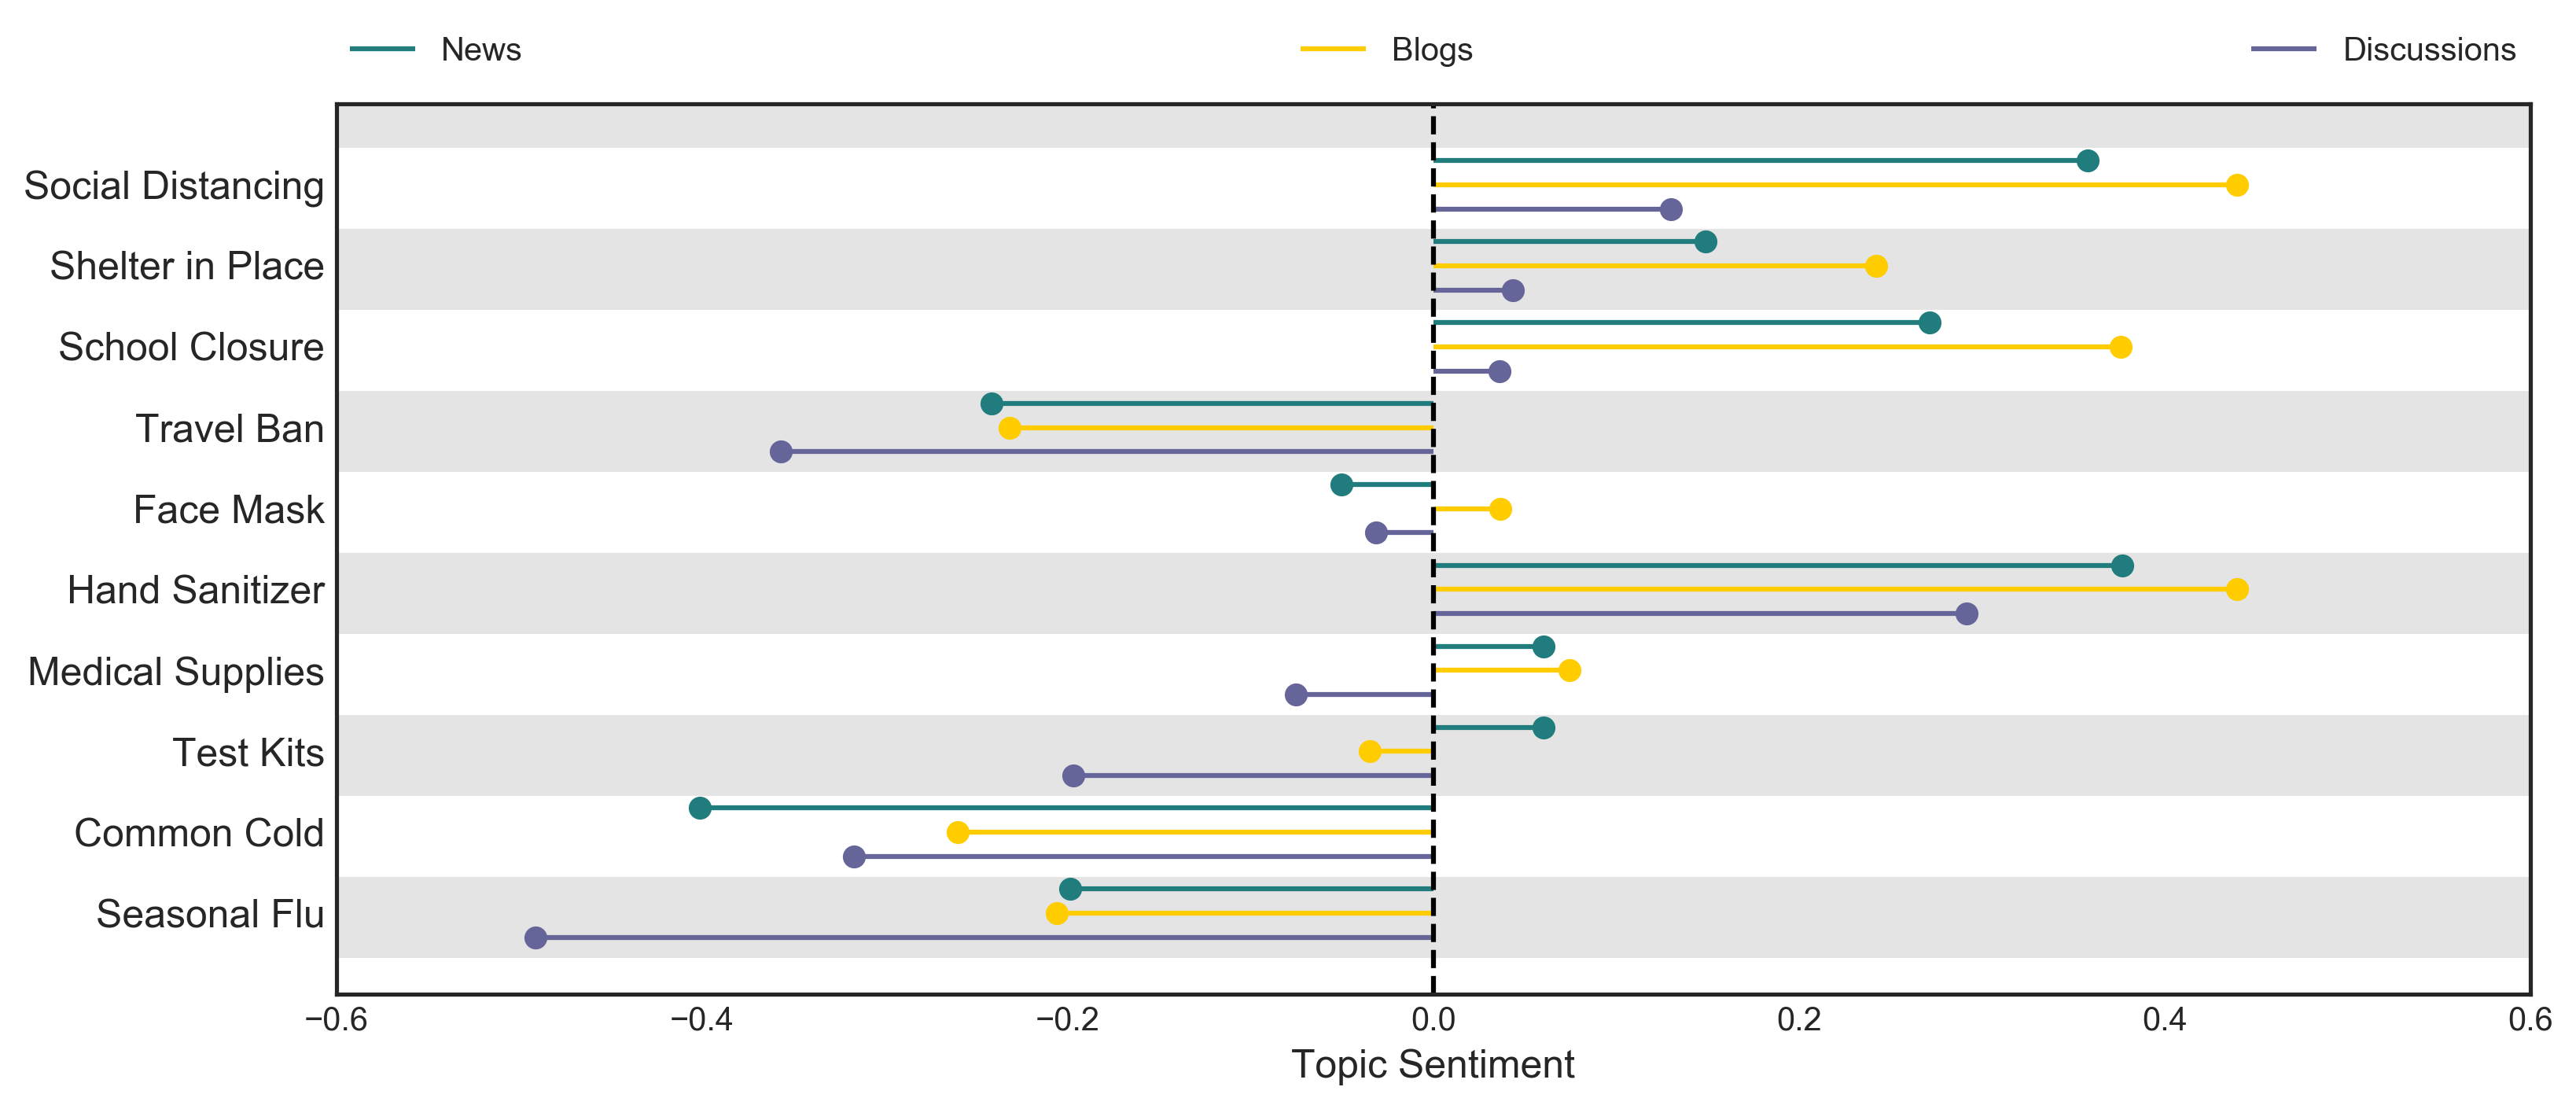

In [28]:
fig = plt.figure(figsize=(12,5), dpi=300)

news_xvalues = topic_statistics[topic_statistics['Source'].str.contains('News')]['Sentiment']
news_yvalues = [10.3,9.3,8.3,7.3,6.3,5.3,4.3,3.3,2.3,1.3]
blogs_xvalues = topic_statistics[topic_statistics['Source'].str.contains('Blogs')]['Sentiment']
blogs_yvalues = [10,9,8,7,6,5,4,3,2,1]
discussions_xvalues = topic_statistics[topic_statistics['Source'].str.contains('Discussions')]['Sentiment']
discussions_yvalues = [9.7,8.7,7.7,6.7,5.7,4.7,3.7,2.7,1.7,0.7]


for i, values in enumerate(zip(news_xvalues, blogs_xvalues, discussions_xvalues)):
    plt.errorbar(x=values[0], y=news_yvalues[i], linestyle='-', fmt='o', c=elm)
    plt.hlines(news_yvalues[i], 0, values[0], color=elm)
    plt.errorbar(x=values[1], y=blogs_yvalues[i], fmt='o', c=orange)
    plt.hlines(blogs_yvalues[i], 0, values[1], color=orange)
    plt.errorbar(x=[values[2]], y=discussions_yvalues[i], fmt='o', c=purple)
    plt.hlines(discussions_yvalues[i], 0, values[2], color=purple)

plt.legend(["News", "Blogs", "Discussions"],bbox_to_anchor=(0., .99, 1., .1), loc=2, ncol=3, mode="expand", borderaxespad=0)

plt.barh(np.arange(0,12,1), 
        [-2]*12, 
        height=1.1,
        color= ["#FFFFFF","#E5E4E4"]*12,
        edgecolor = "none",
       align="center")
plt.barh(np.arange(0,12,1), 
        [2]*12, 
        height=1.1,
        color= ["#FFFFFF","#E5E4E4"]*12,
        edgecolor = "none",
       align="center")

plt.yticks(np.arange(12), ('', 'Seasonal Flu', 'Common Cold', 'Test Kits', 'Medical Supplies',
                           'Hand Sanitizer', 'Face Mask', 'Travel Ban', 'School Closure',
                           'Shelter in Place','Social Distancing'), fontsize=12)

plt.ylim(0,11)
plt.xlim(-.6,.6)

ax = plt.vlines(0, 0, 1000, colors='k', linestyles='dashed')

plt.xlabel("Topic Sentiment", fontsize=12)

plt.show()

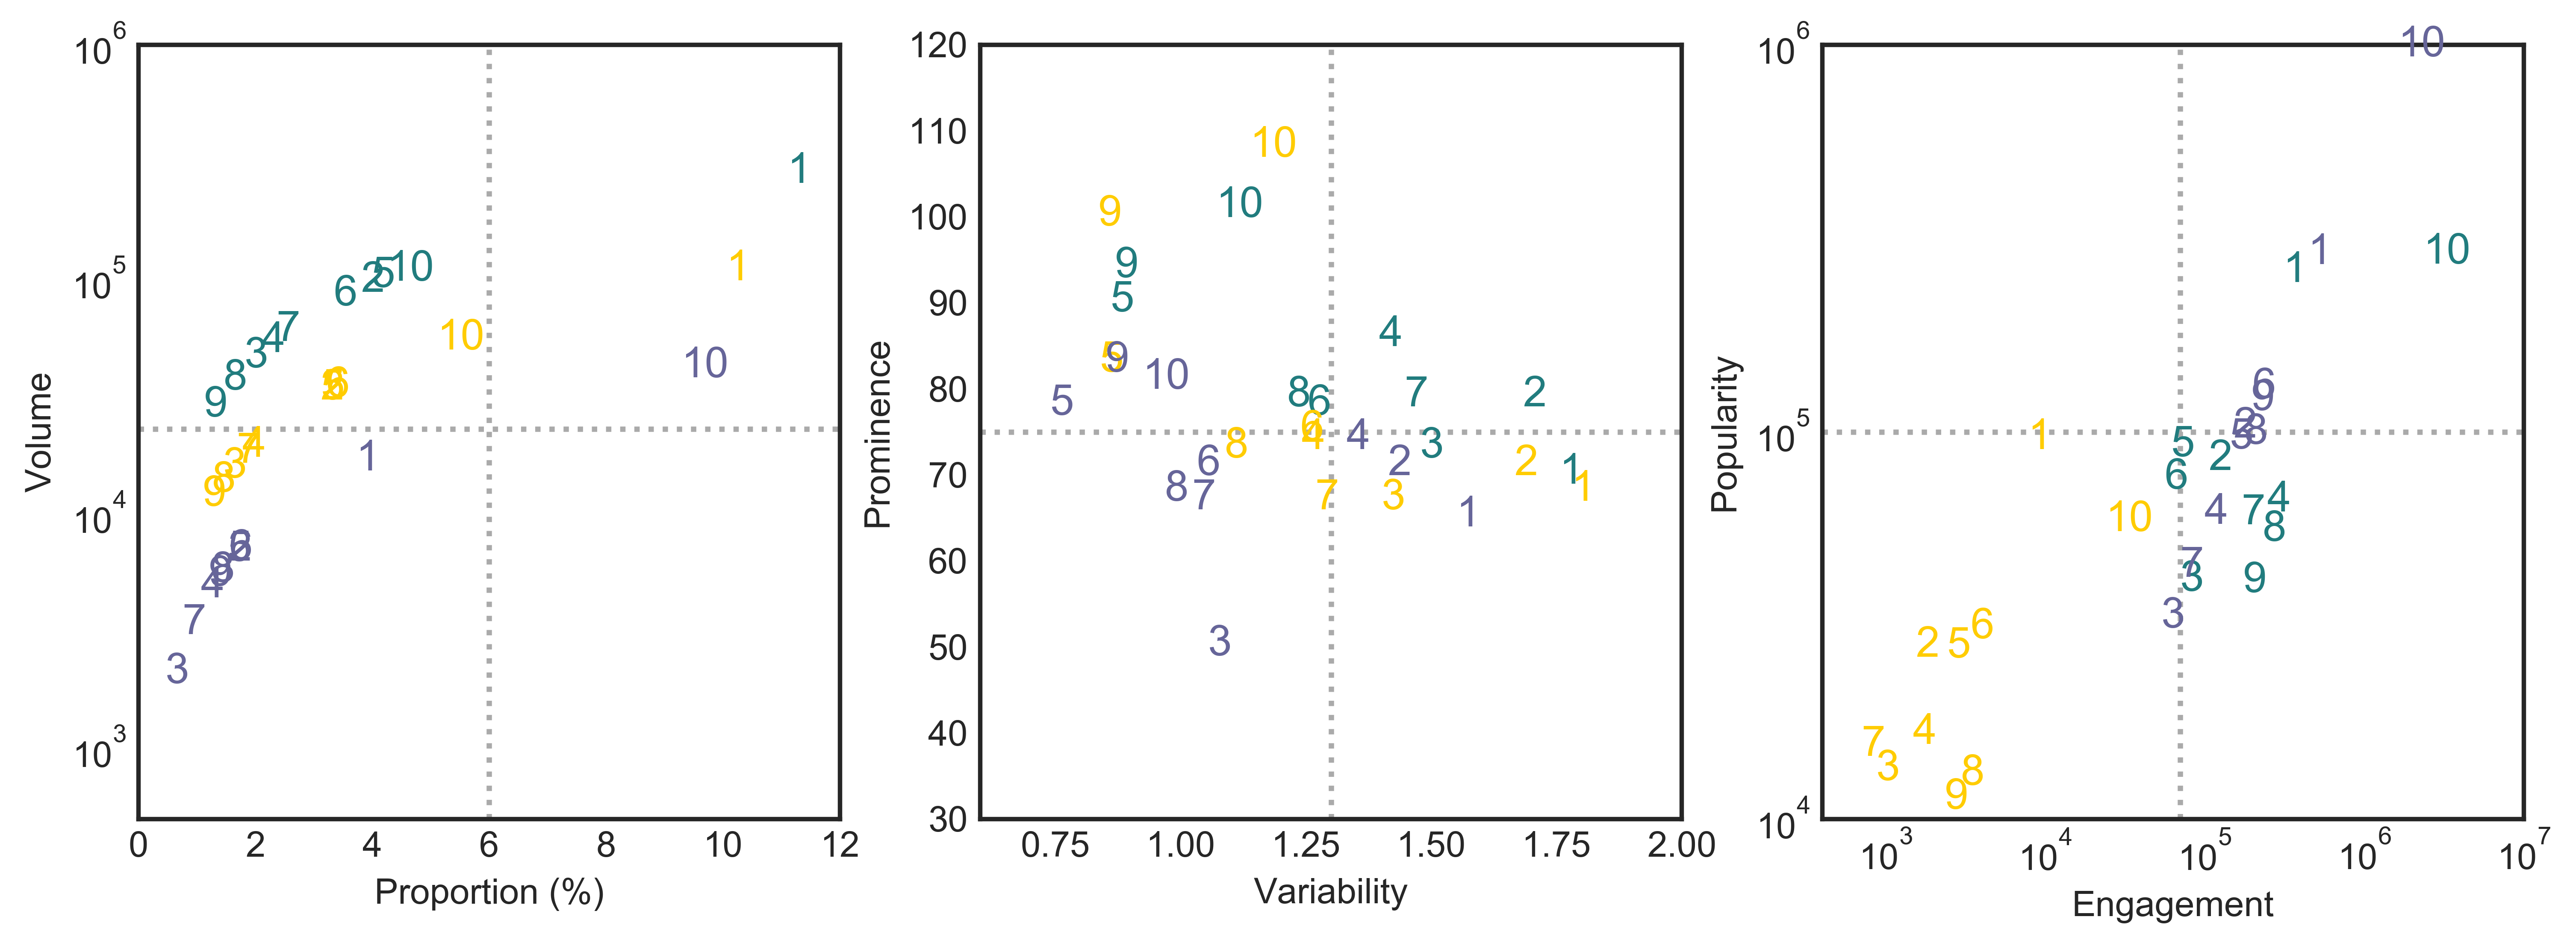

In [29]:
fig = plt.figure(figsize=(12,4), dpi=600)

news_topics = topic_statistics[topic_statistics['Source']=='News']['Topic'].values
blogs_topics = topic_statistics[topic_statistics['Source']=='Blogs']['Topic'].values
discussions_topics = topic_statistics[topic_statistics['Source']=='Discussions']['Topic'].values

## Left Plot

ax = plt.subplot(1, 3, 1)
ax.scatter(topic_statistics[topic_statistics['Source']=='News']['Proportion'].values,
           topic_statistics[topic_statistics['Source']=='News']['Volume'].values,
           color='w')
for i, txt in enumerate(news_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='News']['Proportion'].values[i], 
                      topic_statistics[topic_statistics['Source']=='News']['Volume'].values[i]),
                size=s,
                color=elm)
    
ax = plt.subplot(1, 3, 1)
ax.scatter(topic_statistics[topic_statistics['Source']=='Blogs']['Proportion'].values,
           topic_statistics[topic_statistics['Source']=='Blogs']['Volume'].values,
           color='w')
for i, txt in enumerate(blogs_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='Blogs']['Proportion'].values[i], 
                      topic_statistics[topic_statistics['Source']=='Blogs']['Volume'].values[i]), 
                size=s,
                color=orange)

ax = plt.subplot(1, 3, 1)
ax.scatter(topic_statistics[topic_statistics['Source']=='Discussions']['Proportion'].values,
           topic_statistics[topic_statistics['Source']=='Discussions']['Volume'].values,
           color='w')
for i, txt in enumerate(discussions_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='Discussions']['Proportion'].values[i], 
                      topic_statistics[topic_statistics['Source']=='Discussions']['Volume'].values[i]), 
                size=s,
                color=purple)

ax.vlines(6, 500, 1e6, color=grey, linestyles='dotted')
ax.hlines(23000, 0, 12, color=grey, linestyles='dotted')
ax.set_xlim(0,12)
ax.set_ylim(500,1e6)
ax.set_yscale('symlog')
ax.set_ylabel('Volume')
ax.set_xlabel('Proportion (%)')

## Middle Plot

ax = plt.subplot(1, 3, 2)
ax.scatter(topic_statistics[topic_statistics['Source']=='News']['Variability'].values,
           topic_statistics[topic_statistics['Source']=='News']['Prominence'].values,
           color='w')
for i, txt in enumerate(news_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='News']['Variability'].values[i], 
                      topic_statistics[topic_statistics['Source']=='News']['Prominence'].values[i]),
                size=s,
                color=elm)
    
ax = plt.subplot(1, 3, 2)
ax.scatter(topic_statistics[topic_statistics['Source']=='Blogs']['Variability'].values,
           topic_statistics[topic_statistics['Source']=='Blogs']['Prominence'].values,
           color='w')
for i, txt in enumerate(blogs_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='Blogs']['Variability'].values[i], 
                      topic_statistics[topic_statistics['Source']=='Blogs']['Prominence'].values[i]), 
                size=s,
                color=orange)

ax = plt.subplot(1, 3, 2)
ax.scatter(topic_statistics[topic_statistics['Source']=='Discussions']['Variability'].values,
           topic_statistics[topic_statistics['Source']=='Discussions']['Prominence'].values,
           color='w')
for i, txt in enumerate(discussions_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='Discussions']['Variability'].values[i], 
                      topic_statistics[topic_statistics['Source']=='Discussions']['Prominence'].values[i]), 
                size=s,
                color=purple)

ax.vlines(1.3, 30,120, color=grey, linestyles='dotted')
ax.hlines(75, .6,2, color=grey, linestyles='dotted')
ax.set_xlim(.6,2)
ax.set_ylim(30,120)
ax.set_ylabel('Prominence')
ax.set_xlabel('Variability')


## Right Plot

ax = plt.subplot(1, 3, 3)
ax.scatter(topic_statistics[topic_statistics['Source']=='News']['Engagement'].values,
           topic_statistics[topic_statistics['Source']=='News']['Popularity'].values,
           color='w')
for i, txt in enumerate(news_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='News']['Engagement'].values[i], 
                      topic_statistics[topic_statistics['Source']=='News']['Popularity'].values[i]),
                size=s,
                color=elm)

    
ax = plt.subplot(1, 3, 3)
ax.scatter(topic_statistics[topic_statistics['Source']=='Blogs']['Engagement'].values,
           topic_statistics[topic_statistics['Source']=='Blogs']['Popularity'].values,
           color='w')
for i, txt in enumerate(blogs_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='Blogs']['Engagement'].values[i], 
                      topic_statistics[topic_statistics['Source']=='Blogs']['Popularity'].values[i]), 
                size=s,
                color=orange)

ax = plt.subplot(1, 3, 3)
ax.scatter(topic_statistics[topic_statistics['Source']=='Discussions']['Engagement'].values,
           topic_statistics[topic_statistics['Source']=='Discussions']['Popularity'].values,
           color='w')
for i, txt in enumerate(discussions_topics):
    ax.annotate(i+1, (topic_statistics[topic_statistics['Source']=='Discussions']['Engagement'].values[i], 
                      topic_statistics[topic_statistics['Source']=='Discussions']['Popularity'].values[i]), 
                size=s,
                color=purple)    

ax.vlines(70000, 1e4, 1e6, color=grey, linestyles='dotted')
ax.hlines(1e5, 400, 1e7, color=grey, linestyles='dotted')
ax.set_xlim(400,1e7)
ax.set_ylim(1e4,1e6)

ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.set_xlabel('Engagement')
ax.set_ylabel('Popularity')

plt.show()